## DS4420 - Homework 5
Gavin Wainwright

In [31]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.integrate import quad

#### Question 2

In [3]:
x = genfromtxt('time_with_loved_ones.csv')
y = genfromtxt('happiness_level.csv')

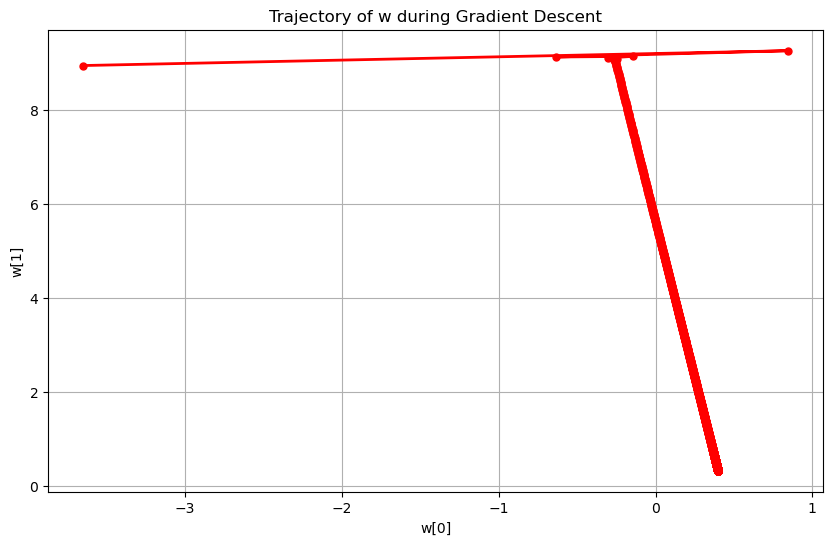

Final weights: 
 [0.39805737 0.33088431]


In [4]:
def gradient_descent(X, y, starting_point=(10.0, 10.0), learning_rate=0.01, iters=10000):
    m, n = X.shape
    w = np.array(starting_point, dtype=float)
    w_trajectory = []

    for _ in range(iters):
        y_pred = X.dot(w)
        gradient = X.T.dot(y_pred - y) / m
        w -= learning_rate * gradient
        w_trajectory.append(w.copy()) # Record the current point

    return w, np.array(w_trajectory)

# Feature mapping to include bias term
def feature_map_linear(x):
    return np.vstack([x, np.ones(len(x))]).T

X = feature_map_linear(x)
w, w_trajectory = gradient_descent(X, y)

# Plot the trajectory
plt.figure(figsize=(10, 6))
plt.plot(w_trajectory[:, 0], w_trajectory[:, 1], 'ro-', markersize=5, lw=2)
plt.title('Trajectory of w during Gradient Descent')
plt.xlabel('w[0]')
plt.ylabel('w[1]')
plt.grid(True)
plt.show()

print(f'Final weights: \n {w}')

#### Question 4

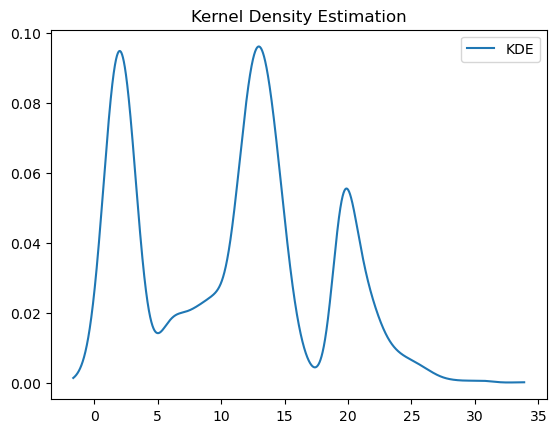

In [16]:
X = genfromtxt('parental_anxiety_vs_kids_age.csv')

def gaussian_kernel(x, x_i, bandwidth):
    return (1 / (bandwidth * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - x_i) / bandwidth) ** 2)

def kde(x, data, bandwidth):
    return np.sum(gaussian_kernel(x, data[:, None], bandwidth), axis=0) / data.size

# Compute KDE
n_samples = 10000
x_kde = np.linspace(min(X), max(X), n_samples)
bandwidth = 0.75
density = kde(x, X, bandwidth)

plt.plot(x, density, label='KDE')
plt.title('Kernel Density Estimation')
plt.legend()
plt.show()

In [19]:
# Polynomial Regression
def polynomial_regression(X, y, degree=5):
    X_poly = np.vander(X, N=degree+1, increasing=True)
    weights = np.linalg.inv(X_poly.T @ X_poly) @ X_poly.T @ y
    return X_poly @ weights

y_poly_pred = polynomial_regression(x_kde, density, degree=5)

# Kernel Regression
def custom_kernel_regression(X, y, bandwidth):
    def predict(x):
        weights = np.exp(-0.5 * ((x - X) / bandwidth) ** 2)
        return np.dot(weights, y) / np.sum(weights)
    return np.vectorize(predict)(X)

y_kr_pred = custom_kernel_regression(x_kde, density, bandwidth=0.75)

# Kernel Ridge Regression
def custom_kernel_ridge_regression(X, y, alpha=1.0, gamma=None):
    if gamma is None:
        gamma = 1.0 / X.shape[0]
    def rbf_kernel(x1, x2):
        distance = np.subtract.outer(x1, x2)
        return np.exp(-gamma * (distance ** 2))
    K = rbf_kernel(X, X)
    n = K.shape[0]
    alpha_coeffs = np.linalg.inv(K + alpha * np.eye(n)) @ y
    K_new = rbf_kernel(X, X)
    return K_new @ alpha_coeffs

y_krr_pred = custom_kernel_ridge_regression(x_kde, density, alpha=0.1, gamma=np.power(0.75, -2))

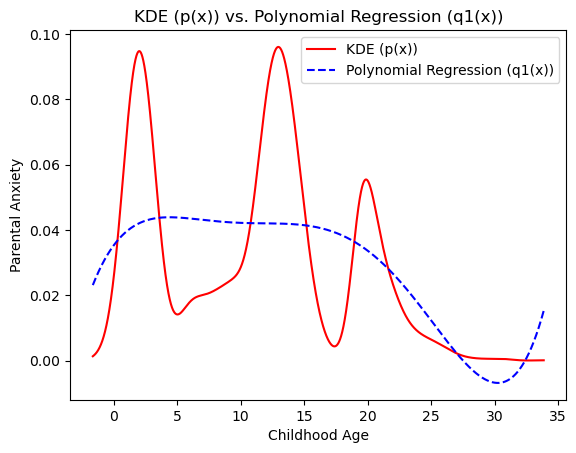

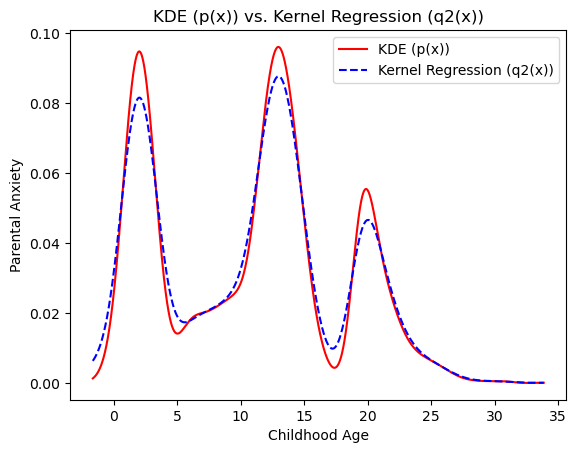

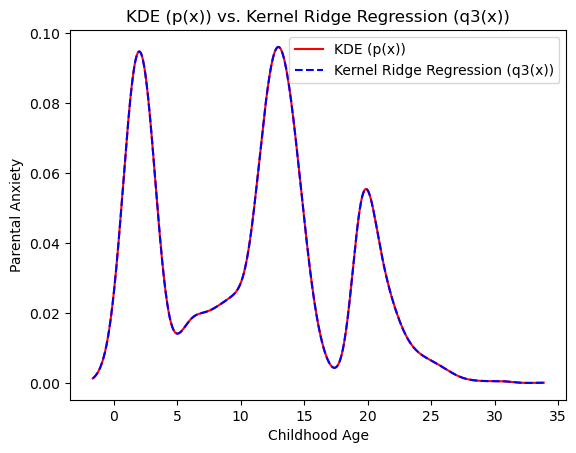

MSE Polynomial Regression: 0.0005006639168293497
MSE Kernel Regression: 1.924192273710372e-05
MSE Kernel Ridge Regression: 1.2276646520061195e-10


In [22]:
# Plot KDE vs. Polynomial Regression
plt.plot(x_kde, density, label='KDE (p(x))', color='red')
plt.plot(x_kde, y_poly_pred, label='Polynomial Regression (q1(x))', linestyle='--', color='blue')
plt.title('KDE (p(x)) vs. Polynomial Regression (q1(x))')
plt.legend()
plt.xlabel('Childhood Age')
plt.ylabel('Parental Anxiety')
plt.show()

# Plot KDE vs. Kernel Regression
plt.plot(x_kde, density, label='KDE (p(x))', color='red')
plt.plot(x_kde, y_kr_pred, label='Kernel Regression (q2(x))', linestyle='--', color='blue')
plt.title('KDE (p(x)) vs. Kernel Regression (q2(x))')
plt.legend()
plt.xlabel('Childhood Age')
plt.ylabel('Parental Anxiety')
plt.show()

# Plot KDE vs. Kernel Ridge Regression
plt.plot(x_kde, density, label='KDE (p(x))', color='red')
plt.plot(x_kde, y_krr_pred, label='Kernel Ridge Regression (q3(x))', linestyle='--', color='blue')
plt.title('KDE (p(x)) vs. Kernel Ridge Regression (q3(x))')
plt.legend()
plt.xlabel('Childhood Age')
plt.ylabel('Parental Anxiety')
plt.show()


# MSE calculations
print('MSE Polynomial Regression:', mean_squared_error(density, y_poly_pred))
print('MSE Kernel Regression:', mean_squared_error(density, y_kr_pred))
print('MSE Kernel Ridge Regression:', mean_squared_error(density, y_krr_pred))

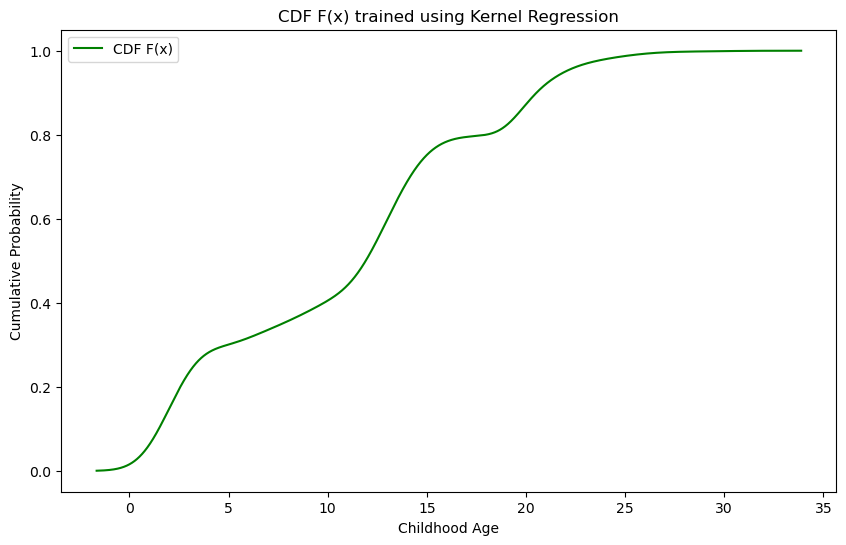

In [27]:
# Train a CDF Function F(x) for p(x)
cdf = np.cumsum(density) * (x_kde[1] - x_kde[0])
cdf /= cdf[-1]

plt.figure(figsize=(10, 6))
plt.plot(x_kde, cdf, label='CDF F(x)', color='green')
plt.title('CDF F(x) trained using Kernel Regression')
plt.xlabel('Childhood Age')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

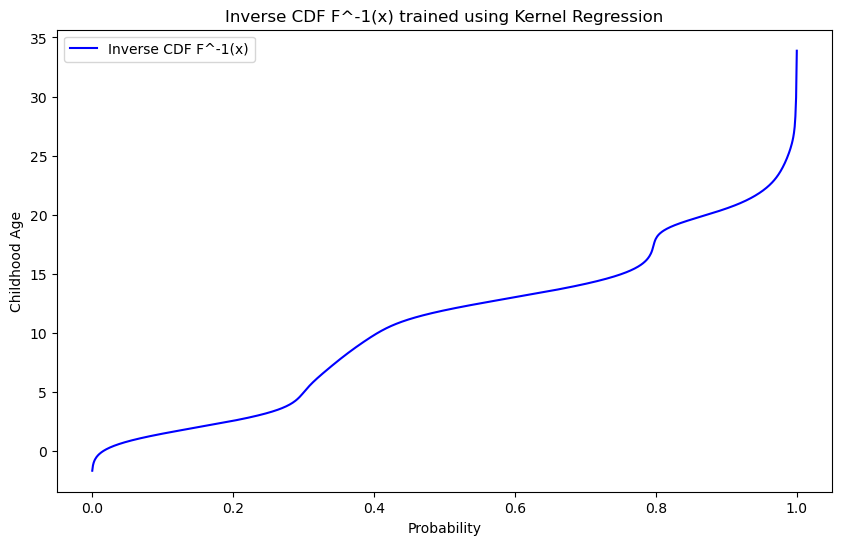

In [28]:
# Train the Inverse CDF Function F^-1(x) for p(x)
def inverse_cdf(probabilities, cdf, x_values):
    return np.interp(probabilities, cdf, x_values)

prob_demo = np.linspace(0, 1, 1000)
x_values_inverse_cdf = inverse_cdf(prob_demo, cdf, x_kde)

plt.figure(figsize=(10, 6))
plt.plot(prob_demo, x_values_inverse_cdf, label='Inverse CDF F^-1(x)', color='blue')
plt.title('Inverse CDF F^-1(x) trained using Kernel Regression')
plt.xlabel('Probability')
plt.ylabel('Childhood Age')
plt.legend()
plt.show()

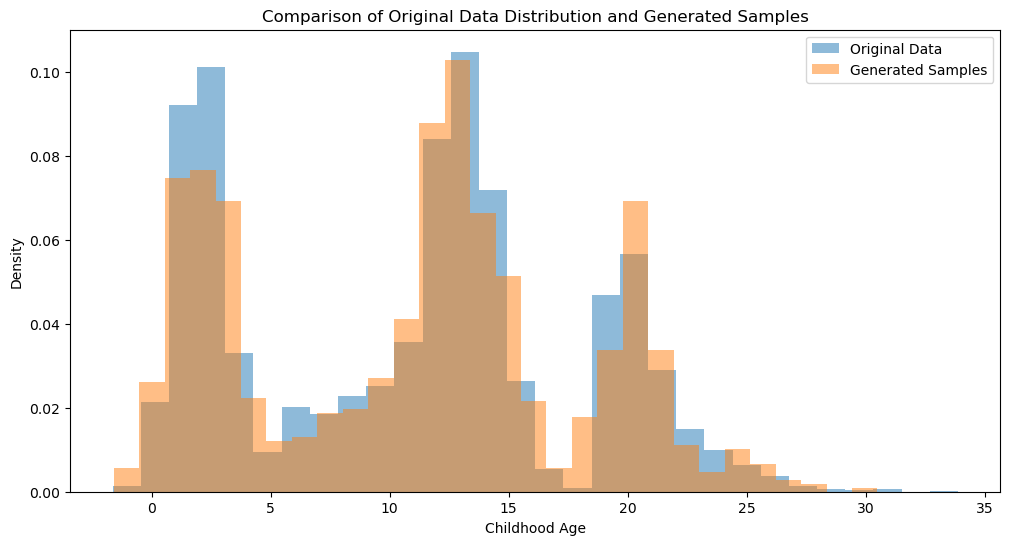

In [29]:
# Given the inverse cdf function, use inversion sampling to generate samples that look like the original dataset

n_samples = 1000
uniform_samples = np.random.uniform(low=0, high=1, size=n_samples)
generated_samples = inverse_cdf(uniform_samples, cdf, x_kde)

plt.figure(figsize=(12, 6))
plt.hist(X, bins=30, alpha=0.5, label='Original Data', density=True)
plt.hist(generated_samples, bins=30, alpha=0.5, label='Generated Samples', density=True)
plt.title('Comparison of Original Data Distribution and Generated Samples')
plt.legend()
plt.xlabel('Childhood Age')
plt.ylabel('Density')
plt.show()

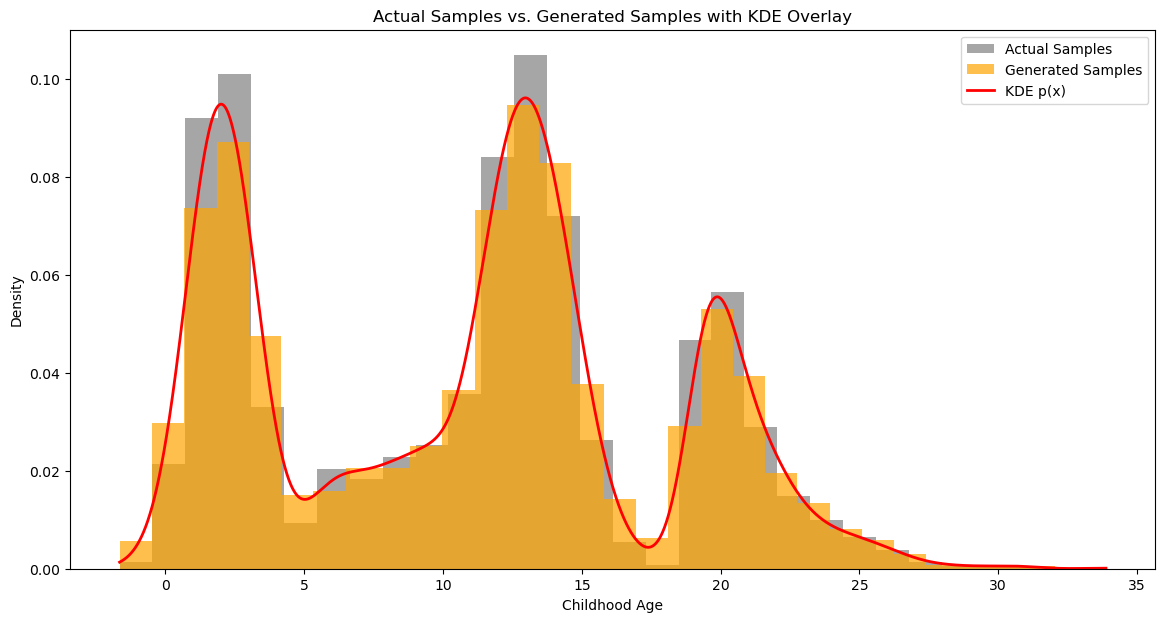

In [30]:
uniform_samples = np.random.uniform(0, 1, size=len(X))
generated_samples = inverse_cdf(uniform_samples, cdf, x_kde)

plt.figure(figsize=(14, 7))
plt.hist(X, bins=30, alpha=0.7, density=True, label='Actual Samples', color='gray')
plt.hist(generated_samples, bins=30, alpha=0.7, density=True, label='Generated Samples', color='orange')

plt.plot(x_kde, density, label='KDE p(x)', color='red', linewidth=2)
plt.legend()
plt.xlabel('Childhood Age')
plt.ylabel('Density')
plt.title('Actual Samples vs. Generated Samples with KDE Overlay')
plt.show()

**If you are a social scientist, provide a possible theory of why the distribution looks the way it does.**

The distribution of parental anxiety across children's ages might reflect key developmental milestones and challenges that parents perceive as particularly stressful or uncertain. For example, early childhood might evoke anxiety due to health concerns and developmental milestones, adolescence could heighten worries related to social integration, independence, and academic pressures, and late teenage years might involve anxiety about the child's transition to adulthood, including career choices and leaving home. These stages represent significant shifts in a child's autonomy and social environments, potentially explaining peaks in parental anxiety.

In [32]:
def p(x):
    return np.interp(x, x_kde, density)

probability_integration, _ = quad(p, 5, 10)

samples_between_5_and_10 = (generated_samples >= 5) & (generated_samples <= 10)
probability_sampling = np.mean(samples_between_5_and_10)

print("Probability (Integration):", probability_integration)
print("Probability (Sampling):", probability_sampling)

Probability (Integration): 0.10440383368332956
Probability (Sampling): 0.09979002099790021


#### Question 5

In [123]:
x = genfromtxt('PCA_LDA_circles.csv', delimiter=',')
y = genfromtxt('PCA_LDA_labels.csv')

# KPCA
# Compute the RBF (Gaussian) kernel matrix
def rbf_kernel(X, gamma):
    sq_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(X**2, axis=1) - 2 * np.dot(X, X.T)
    K = np.exp(-gamma * sq_dists)
    return K

# Center the kernel matrix in feature space
def center_kernel_matrix(K):
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    return K_centered

# Perform Kernel PCA
def kpca(X, gamma, n_components):
    K = rbf_kernel(X, gamma)
    K_centered = center_kernel_matrix(K)
    eigvals, eigvecs = np.linalg.eigh(K_centered)
    top_eigvecs = eigvecs[:, -n_components:]
    X_kpca = np.dot(top_eigvecs.T, K_centered).T
    return X_kpca


gamma = 22
n_components = 2

X_kpca = kpca(x, gamma, n_components)

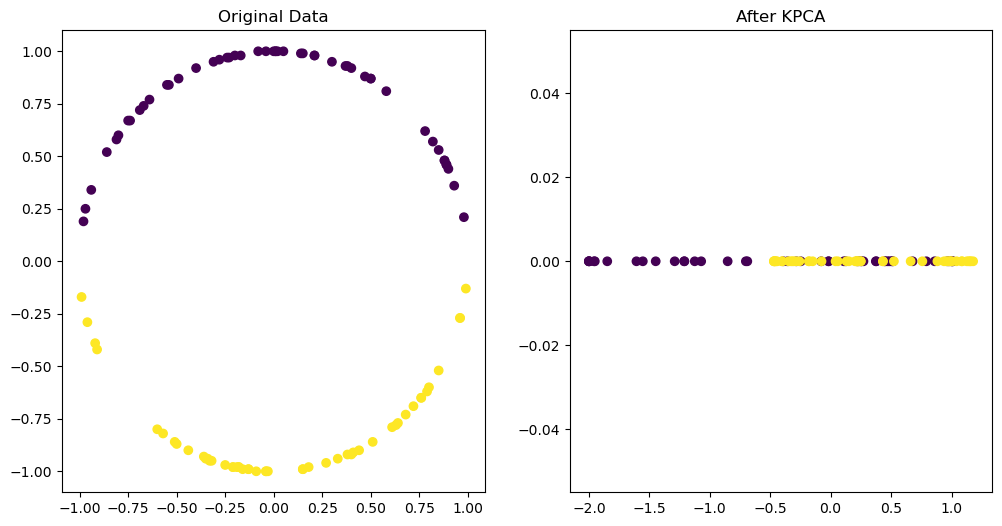

In [124]:
# Original Data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.title('Original Data')

# Transformed Data
plt.subplot(1, 2, 2)
plt.scatter(X_kpca[:, 0], np.zeros_like(X_kpca[:, 0]), c=y)
plt.title('After KPCA')

plt.show()

In [139]:
# KLDA
def rbf_kernel(X1, X2, gamma):
    sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    K = np.exp(-gamma * sq_dists)
    return K

def compute_means(K, y):
    classes = np.unique(y)
    means = np.array([np.mean(K[:, y == c], axis=1) for c in classes])
    return means

def regularize_matrix(S, alpha=1e-4):
    return S + alpha * np.eye(S.shape[0])

def klda(X, y, gamma, alpha=1e-4):
    K = rbf_kernel(X, X, gamma)
    N = K.shape[0]

    one_n = np.ones((N, N)) / N
    K_centered = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    means = compute_means(K_centered, y)

    total_mean = np.mean(K_centered, axis=1)

    S_B = np.sum([(means[i] - total_mean).reshape(-1, 1) @ (means[i] - total_mean).reshape(1, -1) for i in range(len(np.unique(y)))], axis=0)

    S_W = np.sum([np.sum([((K_centered[:, i] - means[int(y[i])]).reshape(-1, 1) @ (K_centered[:, i] - means[int(y[i])]).reshape(1, -1)) for i in range(len(y)) if y[i] == c], axis=0) for c in np.unique(y)], axis=0)
    S_W = regularize_matrix(S_W, alpha=alpha)

    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W).dot(S_B))
    top_eigvec = eigvecs[:, np.argmax(eigvals)]

    X_klda = K_centered.T.dot(top_eigvec)

    return X_klda


gamma = 1
X_klda = klda(x, y, gamma)

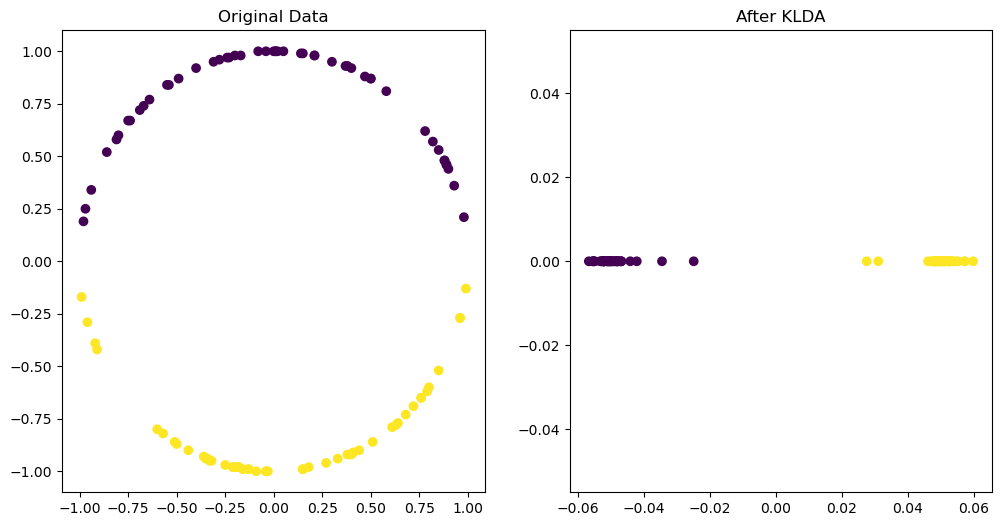

In [140]:
# Original Data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.title('Original Data')

# After KLDA
plt.subplot(1, 2, 2)
plt.scatter(X_klda, np.zeros_like(X_klda), c=y)  # For 1D visualization
plt.title('After KLDA')

plt.show()